# AMAZON PRODUCT RECOMMENDATION ENGINE

## Objective: 

This recommendation engine provides E-commerce product recommendations based on the following approaches: 
- <b><u>Content-based recommendation:</u></b> Finding products with similar product desciptions. This approach can be targeted for new customers or customers with low engagement <i>(Some/No product rating provided)</i>. 
- <b><u>Model-based recommendation:</u></b> Finding similar products using item-item collaborative filtering. This approach can be targeted to recurring or loyal customers <i>(High Product engagement/ Rating)</i>.  


### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import spacy
nlp = spacy.load("en_core_web_sm")
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import math
from wordcloud import WordCloud, STOPWORDS
import ast
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aashe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## Content-based Filtering

<b><u>Dataset Source:</u></b> Amazon product data (http://jmcauley.ucsd.edu/data/amazon/links.html)

**Dataset 1:** Product metadata files for categories – Beauty, Grocery and Gourmet Food, Baby, Musical Instruments, Patio-Lawn and Garden were chosen. These files were appended and used for content-based recommendation

### Reading the data files

In [7]:
df_grocery_meta = pd.read_json("meta_Grocery_and_Gourmet_Food.json",lines=True)
df_baby_meta = pd.read_json("meta_Baby.json",lines=True)
df_beauty_meta = pd.read_json("meta_Beauty.json",lines=True)
df_musical_meta = pd.read_json("meta_Musical_Instruments.json",lines=True)
df_patio_meta = pd.read_json("meta_Patio_Lawn_and_Garden.json",lines=True)


In [8]:
df_grocery_meta['category'] = "grocery"
df_baby_meta['category'] = "baby"
df_musical_meta['category'] = "musical"
df_patio_meta['category'] = "patio_lawn"
df_beauty_meta['category'] = "beauty"

In [9]:
df_metadata = pd.concat([df_grocery_meta,df_baby_meta,df_beauty_meta,df_musical_meta,df_patio_meta])
df_metadata.head()

,asin,description,title,imUrl,related,salesRank,categories,price,brand,category
0,0657745316,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{'also_viewed': ['B001GE8N4Y']},{'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN,grocery
1,0700026444,"Silverpot Tea, Pure Darjeeling, is an exquisit...",Pure Darjeeling Tea: Loose Leaf,http://ecx.images-amazon.com/images/I/51hs8sox...,NaN,{'Grocery & Gourmet Food': 620307},[[Grocery & Gourmet Food]],NaN,NaN,grocery
2,1403796890,Must have for any WWE Fan\n \n \n \nFeaturing ...,WWE Kids Todler Velvet Slippers featuring John...,http://ecx.images-amazon.com/images/I/518SEST5...,NaN,NaN,[[Grocery & Gourmet Food]],3.99,NaN,grocery
3,141278509X,Infused with Vitamins and Electrolytes Good So...,Archer Farms Strawberry Dragonfruit Drink Mix ...,http://ecx.images-amazon.com/images/I/51CFQIis...,{'also_viewed': ['B0051IETTY']},{'Grocery & Gourmet Food': 620322},[[Grocery & Gourmet Food]],NaN,NaN,grocery
4,1453060375,MiO Energy is your portable energy source givi...,Mio Energy Liquid Water Enhancer Black Cherry ...,http://ecx.images-amazon.com/images/I/51EUsMcn...,"{'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...",{'Grocery & Gourmet Food': 268754},[[Grocery & Gourmet Food]],11.99,Mio,grocery


In [ ]:
df_metadata = df_metadata.drop(columns = ['brand','imUrl','related','salesRank','categories','price'])

### Distribution of Product Categories

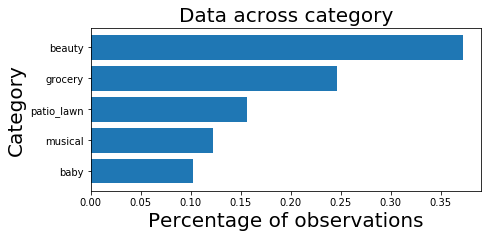

In [22]:
category_distribution = pd.DataFrame(df_metadata['category'].value_counts(normalize = True)).sort_values(by=['category'])
plt.figure(figsize=(7,3))
plt.barh(y = category_distribution.index, width = category_distribution['category'])
plt.xlabel("Percentage of observations",fontsize=20)
plt.ylabel("Category",fontsize=20)
plt.title("Data across category",fontsize=20)
plt.show()

In [23]:
df_metadata.to_csv("df_metadata.csv")
# df_metadata = pd.read_csv("df_metadata.csv")

### Data Preprocessing

In [24]:
df_metadata_sample = df_metadata.sample(frac=0.10)

In [25]:
pd.DataFrame(df_metadata_sample.isna().sum(),columns = ['Count of Nulls'])

,Count of Nulls
asin,0
description,6366
title,1109
category,0


In [26]:
df_metadata_sample.dropna(inplace=True)
pd.DataFrame(df_metadata_sample.isna().sum(),columns = ['Count of Nulls'])

,Count of Nulls
asin,0
description,0
title,0
category,0


In [28]:
df_metadata_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62344 entries, 30726 to 257163
Data columns (total 4 columns):
asin           62344 non-null object
description    62344 non-null object
title          62344 non-null object
category       62344 non-null object
dtypes: object(4)
memory usage: 2.4+ MB


In [29]:
### Object to String Conversion
df_metadata_sample['description'] = df_metadata_sample['description'].astype('str')  
df_metadata_sample['category'] = df_metadata_sample['category'].astype('str')    
df_metadata_sample['title'] = df_metadata_sample['title'].astype('str') 

df = df_metadata_sample.copy() ### Backup

### Product Description Cleaning

Word Embeddings will be created using the **Product Descriptions** and hence needs to be cleaned. The cleaning process involves<br>
- Stopwords removal
- Punctuations removal
- Lemmatization - Finding the root words for each word. This will reduce the overall vocabulary size.


In [34]:
def cleaning(description):
    
    ###Stopword Removal
    stop = stopwords.words('english')
    description = description.split()
    cleaned = " ".join([item for item in description if item.lower() not in stop])
    cleaned = cleaned.replace("'", "").lower()
    cleaned=re.sub(r'[^\w\s]',' ',cleaned)   ###Punctuation removal
    
    ###Lemmatization
    nlp_lemma = nlp(cleaned)
    cleaned = " ".join([item.lemma_ for item in nlp_lemma])
    
    return cleaned

### Extracting nouns and adjectives from the Product Descriptios

In my opinion, nouns and adjectives of the descriptions are going to be the major part of speeches that will help in understanding the product category.

Spacy library's **POS tagging** is used here to perform this action

In [35]:
def clean_pos(description):
    plot = nlp(description)
    tags = [i for i in plot if i.tag_ == 'NN' or i.tag_ == 'NNS' or i.tag_ == 'JJ' or i.tag_ == 'JJR' or i.tag_ == 'JJS']
    return tags

### Applying the above functions on the data

In [38]:
df['description_cleaned']=df['description'].apply(cleaning)
df.head()

,asin,description,title,category,description_cleaned
30726,B0041F2CDI,Valcobaby Glo Bugz safety lights provide a sim...,Valco Baby Glo Bugz Flashing Safety Lights,baby,valcobaby glo bugz safety light provide simple...
18918,B000EEJ9WC,Dunlop 4461 Glow Standard Pick Cabinet - 216 P...,Dunlop 4461 Glow Standard Pick Cabinet - 216 P...,musical,dunlop 4461 glow standard pick cabinet 216 ...
96510,B00CJ0MZ0W,Features:*Canopy for 13 Feet 8-rib Market Umbr...,13 ft 8 Rib Patio Replacement Outdoor Umbrella...,patio_lawn,feature canopy 13 foot 8 rib market umbrella...
68282,B00375LB30,Colorful Non-Pareils make decorating your cake...,"CK Products 16 Ounce Bag of Non Pareil, Mixed",grocery,colorful non pareil make decorate cake cupca...
61277,B002IIPRIM,Pollastrini Di Anzio Sardines in olive oil wit...,Pollastrini Di Anzio Italian Sardines in Olive...,grocery,pollastrini di anzio sardine olive oil chili p...


In [41]:
df['description_tags']=df['description_cleaned'].apply(clean_pos)
df.head()

,asin,description,title,category,description_cleaned,description_tags
30726,B0041F2CDI,Valcobaby Glo Bugz safety lights provide a sim...,Valco Baby Glo Bugz Flashing Safety Lights,baby,valcobaby glo bugz safety light provide simple...,"[safety, light, simple, solution, visible, nig..."
18918,B000EEJ9WC,Dunlop 4461 Glow Standard Pick Cabinet - 216 P...,Dunlop 4461 Glow Standard Pick Cabinet - 216 P...,musical,dunlop 4461 glow standard pick cabinet 216 ...,"[standard, pick, cabinet, pick]"
96510,B00CJ0MZ0W,Features:*Canopy for 13 Feet 8-rib Market Umbr...,13 ft 8 Rib Patio Replacement Outdoor Umbrella...,patio_lawn,feature canopy 13 foot 8 rib market umbrella...,"[feature, canopy, foot, rib, market, umbrella,..."
68282,B00375LB30,Colorful Non-Pareils make decorating your cake...,"CK Products 16 Ounce Bag of Non Pareil, Mixed",grocery,colorful non pareil make decorate cake cupca...,"[colorful, cake, cupcake, cookie, fun, multipl..."
61277,B002IIPRIM,Pollastrini Di Anzio Sardines in olive oil wit...,Pollastrini Di Anzio Italian Sardines in Olive...,grocery,pollastrini di anzio sardine olive oil chili p...,"[town, sardine, wild, catch, use, olive, oil]"


In [42]:
df.to_csv("df_cleaned.csv")

### Calculate the extracted POS tags length for each observation

In [43]:
df['description_tags_length']  = df['description_tags'].apply(lambda x: len(x))

### Outlier Detection

In [44]:
pd.DataFrame(df['description_tags_length'].describe())

,description_tags_length
count,62344.000000
mean,30.180178
std,34.348661
min,0.000000
25%,9.000000
50%,21.000000
75%,40.000000
max,2033.000000


In [45]:
outlier_threshold = df['description_tags_length'].quantile(0.75) + 1.5*(df['description_tags_length'].quantile(q=0.75) - df['description_tags_length'].quantile(q=0.25))
outlier_threshold

86.5

In [46]:
df = df[df['description_tags_length'] < math.ceil(outlier_threshold)]
pd.DataFrame(df['description_tags_length'].describe())

,description_tags_length
count,58654.000000
mean,24.334095
std,19.849889
min,0.000000
25%,9.000000
50%,20.000000
75%,35.000000
max,86.000000


### Tokenization and Sequence Generation

- This process involves creating a **unique integer id** for each token or word in the plot tags (As Neural Networks accept only numerical inputs)
- Both frequently and rarely occuring words are removed from the data for better training purposes as frequent words will not help much in discerning the genres and vice-versa for rare words. <br> 
- **Thresholds** have been set to remove these words from the tokenized dictionary (i.e) Words occuring less than 100 times and words occuring more than 1000 times throughout the data are removed.

In [97]:
token = Tokenizer()
token.fit_on_texts(df['description_tags'].astype('str'))

count_lower_thres = 100
count_upper_thres = 1000
rare_words = [w for w,c in token.word_counts.items() if c <= count_lower_thres]
frequent_words = [w for w,c in token.word_counts.items() if c > count_upper_thres]
remove_words = rare_words + frequent_words

for w in remove_words:
    num = token.word_index[w]
    del token.word_index[w]
    del token.word_docs[w]
    del token.word_counts[w]
    del token.index_word[num]
    del token.index_docs[num]
    
df['description_tags_num_rep']= token.texts_to_sequences(df['description_tags'].astype('str'))

In [98]:
len(token.word_counts.items())

1974

In [99]:
df['num_rep_length']  = df['description_tags_num_rep'].apply(lambda x: len(x))
pd.DataFrame(df['num_rep_length'].describe())

,num_rep_length
count,54189.000000
mean,10.930226
std,8.849514
min,0.000000
25%,4.000000
50%,9.000000
75%,16.000000
max,57.000000


In [100]:
df = df[df['num_rep_length'] != 0]

### Target Variable Encoding

In [102]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(df['category'])
lb.classes_

array(['baby', 'beauty', 'grocery', 'musical', 'patio_lawn'], dtype='<U10')

### Padding and Data Partitioning

In [103]:
x = pad_sequences(df['description_tags_num_rep'], maxlen=57, padding='post')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)


In [105]:
df_padded = pd.DataFrame(pad_sequences(df['description_tags_num_rep'], maxlen=57, padding='post'))
df_padded.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,387,340,1200,303,1021,454,422,760,1470,1650,...,0,0,0,0,0,0,0,0,0,0
1,658,1721,658,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,921,359,805,369,291,1561,925,509,395,758,...,0,0,0,0,0,0,0,0,0,0
3,640,535,1873,374,788,515,915,1325,1136,0,...,0,0,0,0,0,0,0,0,0,0
4,2101,540,1252,296,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Implementation - Word Embedding

Embedding neural network has an embedding layer which requires parameter like <br>

- Maximum interger index of the vocabulary (tokenized dictionary) <br>
- Number of dimensions for each word representation 

Each word in the vocabulary is represented by specified n-dimensional dense vectors also known as weights in n-dimensional space (These weights are initially some random real values). The embedding layer maps the vocabulary index input to retrieve its corresponding weights vector whenever that word is sent as an input to the model. <br>*For example, in a five-dimensional space, word "cocoa" may have it's weight vector as [0.5, 0.22, 0.19, 0, 0.8]* <br><br>
These weight vectors are trained against product categories, and during the training the model tries to update the weights in the embedding space in such a way that the weight vectors with the same genre are placed close to each other in that embedding space.
    
**The goal of the model is to train the weights for each word with product categories as its target variable** and the resultant weights that we get after the training process are called embedding weights or embeddings.

In [106]:
model = Sequential()
model.add(Embedding(max(token.index_word)+1, 10, input_length=57))    ### Vocab size + 1
model.add(Flatten())
model.add(Dropout(0.65))                 ### To avoid overfitting
model.add(Dense(20, activation='relu'))  ### Having a dense layer is optional
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy')
print(model.summary())  # summarize the model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 57, 10)            22500     
_________________________________________________________________
flatten_2 (Flatten)          (None, 570)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 570)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                11420     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 105       
Total params: 34,025
Trainable params: 34,025
Non-trainable params: 0
_________________________________________________________________
None


### Fitting the model

In [107]:
model.fit(X_train, y_train, epochs=50, class_weight = "balanced", batch_size = 200, verbose=0)

### Model Evaluation

In [421]:
predictions=model.predict(X_test)
class_predictions = np.zeros_like(predictions)
class_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1
print(classification_report(y_test, class_predictions, target_names = lb.classes_))

              precision    recall  f1-score   support

        baby       0.88      0.83      0.85      1736
      beauty       0.89      0.92      0.91      6013
     grocery       0.89      0.91      0.90      3991
     musical       0.88      0.84      0.86      1620
  patio_lawn       0.88      0.85      0.86      2677

   micro avg       0.89      0.89      0.89     16037
   macro avg       0.88      0.87      0.88     16037
weighted avg       0.89      0.89      0.89     16037
 samples avg       0.89      0.89      0.89     16037



### Extracting embeddings

In [111]:
embedding_layer = model.get_layer(name="embedding_2")
weights = embedding_layer.get_weights()[0]

### Find Similar Words

In [172]:
def find_similar_words(word,n):
    similar_matrix = np.dot(weights, weights[token.word_index[word]])
    similar_scores = np.sort(similar_matrix)[::-1][:n]
    index_similar = np.argsort(similar_matrix)[-n:][::-1]

    similar_words = []
    for i in index_similar:
        similar_words.append(token.index_word[i])
    return similar_words

### Product Similarity Calculation

In [305]:
def similar_products_calculation(tags, category, similar_items,input_description_category):
    
    category_match = 0
    tags = set(tags)
    if category == input_description_category:
        category_match = 0.1  
        
    jaccard_score = len(set(similar_items).intersection(tags)) / len(set(similar_items).union(tags))    
    return jaccard_score + category_match

### Item Recommendation

In [306]:
def recommendation(title):

    input_description_tags = df[df['title'] == title]['description_tags_num_rep'].tolist()[0]
    input_description_category = df[df['title'] == title]['category'].tolist()[0]
    input_description = df[df['title'] == title]['description'].tolist()[0]
    print("\nProduct description of " +title+ " :\n")
    print(input_description)
    
    word1 = token.index_word[input_description_tags[0]]    
    print("\nThe top 5 words similar to " +word1+ " are " ,find_similar_words(word1,5))
    
    similar_items = []
    for i in input_description_tags:
        similar_items.extend(np.argsort(np.dot(weights, weights[i]))[-4:][::-1].tolist())

    df_similar_items = pd.DataFrame()
    df_similar_items['title'] = df['title']
    df_similar_items['category'] = df['category']

    df_similar_items['jaccard_score']=df.apply(lambda x: similar_products_calculation(x.description_tags_num_rep, x.category,similar_items,input_description_category),axis=1)
    df_similar_items = df_similar_items.sort_values(by="jaccard_score", ascending = False).head(10)
    print("\nRecommended Items")
    return df_similar_items['title'].tolist()

### Word similarities with respect to product category

In [433]:
# token.word_counts.items()
find_similar_words("cocoa",10)

['brewer',
 'calorie',
 'carbohydrate',
 'taffy',
 'garlic',
 'cashew',
 'pasta',
 'pretzel',
 'toast',
 'noodle']

### Product Recommendation using content-based filtering

In [435]:
input_title = input("Enter the product title: ")
recommendation(input_title)

Enter the product title: Lawn Mower Blade, 21-5/8 In.

Product description of Lawn Mower Blade, 21-5/8 In. :

Lawn Mower Blade, Straight, For Use With Toro 22 In. recycler with steel deck, Application Toro/108-9764-03, Length 21-5/8 In., Size W 2-1/4 In. Thickness .134 Center Hole 7/16 In.

The top 5 words similar to mower are  ['patio', 'mower', 'stake', 'lawn', 'hose']

Recommended Items


['Lawn Mower Engine Control Cable for AYP 176556',
 'Honda HRR216 VXA VYA Lawn Mower Service Repair Shop Manual',
 'Claber 90764 Basic Drip Kit',
 'Backyard Basics Lawn Mower / Snow Thrower Cover',
 'Tusco Products HP01TC Hose Pot, Terra Cotta (Discontinued by Manufacturer)',
 'Color Changing Sprinkler',
 'Pyle PVCTBLCH46 Armor Shield Patio Table and Chair Set Cover, 70 by 23-Inch, Fits Round Table and 6 Standard Chairs',
 'Replacement part For Toro Lawn mower # 114-1588 CHARGER-BATTERY, FUJIKON',
 'Suncast 8-Inch Metal Garden Stakes, Silver (Pack of 4)',
 'John Deere Original Lawn Tractor Deluxe Large Cover #LP93647']

# Collaborative Filtering

**Dataset 2:** User Ratings/Reviews files for categories – Beauty, Grocery and Gourmet Food, Baby, Musical Instruments, Patio-Lawn and Garden were chosen. These files were appended and used for collaborative filtering

In [3]:
df_baby = pd.read_json("Baby_5.json",lines = True )
df_beauty = pd.read_json("Beauty_5.json",lines = True )
df_grocery = pd.read_json("Grocery_and_Gourmet_Food_5.json",lines = True )
df_musical = pd.read_json("Musical_Instruments_5.json",lines = True )
df_patio_lawn = pd.read_json("Patio_Lawn_and_Garden_5.json",lines = True )

df_ratings = pd.concat([df_grocery,df_baby,df_beauty,df_musical,df_patio_lawn])
df_ratings = df_ratings[["asin","overall","reviewerID"]]
df_ratings = df_ratings.sample(frac = 0.1)

In [4]:
df_ratings.head()

,asin,overall,reviewerID
128401,B005QPE0W8,4,A2NIVKEGUT4WEK
134292,B006SFUEF2,5,A3NH1SMW111SY2
11212,B00070QF20,1,A6T1RHMQ9NSE4
189705,B00GTC03OG,3,A34BZM6S9L7QI4
89416,B0037W6NZO,3,ASXKOIXZ4LPZ2


### Removing the Users who rate the products rarely

In [5]:
temp = pd.DataFrame(df_ratings['reviewerID'].value_counts()).reset_index()
temp.columns = ['user','Count of reviews']
rare_reviewing_users = temp[temp['Count of reviews'] < 3]['user'].tolist()

df_ratings_filtered = df_ratings[~df_ratings['reviewerID'].isin(rare_reviewing_users)]
pd.DataFrame(df_ratings_filtered['reviewerID'].value_counts()).tail()

,reviewerID
A1KK3T8I5WY5MB,3
ANUUF3N6B9NTA,3
A3J30T6XOU0BWS,3
A16KNLKH7JYA1I,3
A1QD39VRMLDNY,3


In [10]:
df_ratings_metadata = df_ratings_filtered.merge(df_metadata[['asin','title','category']],how='inner',on="asin")

### Pivot Table of user-item ratings

In [11]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_user_item = df_ratings_filtered.pivot(
    index='asin',
    columns='reviewerID',
    values='overall'
).fillna(0)
df_user_item_matrix = csr_matrix(df_user_item.values)
df_user_item_matrix

<10360x4643 sparse matrix of type '<class 'numpy.float64'>'
	with 21203 stored elements in Compressed Sparse Row format>

### K-NN model implementation

In [12]:
from sklearn.neighbors import NearestNeighbors
#make an object for the NearestNeighbors Class.
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit the dataset
knn_model.fit(df_user_item_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

### Collaborative Filtering

In [13]:
def collaborative_filtering(title):
    product_id = df_ratings_metadata[df_ratings_metadata['title'] == title]['asin'].unique()[0]
    distance, indices  = knn_model.kneighbors(np.array(df_user_item.loc[product_id,:]).reshape(1, -1), n_neighbors = 6)
    for i in range (len(distance.flatten())):
        if i == 0:
            print("\n",df_ratings_metadata[df_ratings_metadata['asin'] == product_id]['title'].unique().tolist(),"\n")
            print("Recommended products\n")
        else:
            recommended_item = df_user_item.index[indices.flatten()[i]]
            print(df_ratings_metadata[df_ratings_metadata['asin'] == recommended_item]['title'].unique().tolist())
            print(df_ratings_metadata[df_ratings_metadata['asin'] == recommended_item]['category'].unique().tolist(),"\n")

### Product recommendations using Collaborative-based filtering

In [14]:
input_title = input("Enter the product title: ")
collaborative_filtering(input_title)

Enter the product title: Baby Banana Bendable Training Toothbrush, Infant

 ['Baby Banana Bendable Training Toothbrush, Infant'] 

Recommended products

['Graco SimpleSwitch Highchair and Booster, Zooland']
['baby'] 

['12x16 Toddler Pillow (Playful Monkey)']
['baby'] 

['My Brest Friend Slipcover, Leaf']
['baby'] 

['26-Piece Foam Puzzle Play Mat - Solid Colored']
['baby'] 

['Chicco Lil Piano Splash Walker']
['baby'] 

